Low head Dam detection from Satellite images

Importing required packages

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, BatchNormalization, Conv2D, MaxPool2D, Activation, MaxPooling2D, Dropout,AveragePooling2D, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import os

Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining directories

In [ ]:
train_dam_dir='/content/drive/My Drive/data/train/Dams/' #training dir with dam images
train_nodam_dir='/content/drive/My Drive/data/train/NoDams/'  # training dir with no dam images
test_dam_dir='/content/drive/My Drive/data/test/Dams/'  #test dir with dam images
test_nodam_dir='/content/drive/My Drive/data/test/NoDams/'    #test dir with no dam images


In [ ]:
print("The number of images with dams in the training set labelled 'yes':", len(os.listdir(train_dam_dir)))
print("The number of images with no dams in the training set labelled 'no':", len(os.listdir(train_nodam_dir)))
print("The number of images with dams test set labelled 'yes':", len(os.listdir(test_dam_dir)))
print("The number of images with no dams test set labelled 'no':", len(os.listdir(test_nodam_dir)))

The number of images with dams in the training set labelled 'yes': 130
The number of images with no dams in the training set labelled 'no': 143
The number of images with dams test set labelled 'yes': 32
The number of images with no dams test set labelled 'no': 36


Image data generator for train set - rescale, shear, zoom, horizontal and vertical flips

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                             shear_range=0.2,
                                              zoom_range=0.2,
                                              horizontal_flip=True,
                                              vertical_flip = True, validation_split = 0.2)

Image data generator for test set - Rescale

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,)

Loading training images from directory

In [ ]:
train_x = train_datagen.flow_from_directory('/content/drive/My Drive/data/train',
                                            class_mode = 'binary', 
                                            batch_size = 32,
                                            target_size = (500,500))

Found 273 images belonging to 2 classes.


Loading testing images from directory

In [ ]:
test_x = test_datagen.flow_from_directory('/content/drive/My Drive/data/test', class_mode='binary',
                                            batch_size=32, shuffle=False,
                                            target_size = (500,500))

Found 68 images belonging to 2 classes.


Label representation

In [ ]:
test_x.class_indices

{'Dams': 0, 'NoDams': 1}

Class weights

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_x.classes), 
                train_x.classes)

In [ ]:
class_weights = dict(enumerate(class_weights))

In [ ]:
class_weights

{0: 1.05, 1: 0.9545454545454546}

In [ ]:
class_weights_test = class_weight.compute_class_weight(
               'balanced',
                np.unique(test_x.classes), 
                test_x.classes)
class_weights_test = dict(enumerate(class_weights_test))
class_weights_test

{0: 1.0625, 1: 0.9444444444444444}

Defining model

In [ ]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3), padding="valid"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu', padding='valid'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.1))
model3.add(Conv2D(128, (3, 3), activation='relu', padding='valid'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.1))
model3.add(Conv2D(128, (3, 3), activation='relu', padding='valid'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(256, (3, 3), activation='relu', padding='valid'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.1))
model3.add(Conv2D(512, (2, 2), activation='relu', padding='valid'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.1))
model3.add(Conv2D(512, (2, 2), activation='relu', padding='valid'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.1))
model3.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model3.add(Dense(32, activation=tf.nn.relu))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation=tf.nn.relu))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(Dense(128, activation=tf.nn.relu))
model3.add(Dropout(0.2))
model3.add(Dense(256, activation=tf.nn.relu))
model3.add(Dropout(0.2))
model3.add(Dense(1,activation=tf.nn.sigmoid))

In [ ]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 498, 498, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 247, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 121, 121, 128)     73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 60, 60, 128)      

Defining evaluation metrics

In [ ]:
import keras
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      
]


Compiling and running the model

In [ ]:
model3.compile(optimizer='Adam', 
              loss='binary_crossentropy', 
              metrics=METRICS)

In [ ]:
from keras import callbacks
# simple early stopping
es = callbacks.EarlyStopping(monitor='accuracy', mode='max', verbose=1)

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='accuracy',verbose=0,save_best_only=True,mode='max')

In [ ]:
history = model3.fit(train_x, epochs=20, shuffle=True,  class_weight= class_weights,callbacks=[checkpoint])

Epoch 1/20
9/9 [==============================] - 17s 2s/step - loss: 0.6908 - accuracy: 0.5678 - precision: 0.5940 - recall: 0.5524
Epoch 2/20
9/9 [==============================] - 17s 2s/step - loss: 0.5160 - accuracy: 0.7839 - precision: 0.7877 - recall: 0.8042
Epoch 3/20
9/9 [==============================] - 16s 2s/step - loss: 0.4286 - accuracy: 0.8059 - precision: 0.8000 - recall: 0.8392
Epoch 4/20
9/9 [==============================] - 14s 2s/step - loss: 0.4149 - accuracy: 0.8059 - precision: 0.7848 - recall: 0.8671
Epoch 5/20
9/9 [==============================] - 17s 2s/step - loss: 0.3548 - accuracy: 0.8462 - precision: 0.8389 - recall: 0.8741
Epoch 6/20
9/9 [==============================] - 17s 2s/step - loss: 0.3140 - accuracy: 0.8718 - precision: 0.8857 - recall: 0.8671
Epoch 7/20
9/9 [==============================] - 16s 2s/step - loss: 0.3054 - accuracy: 0.8901 - precision: 0.8951 - recall: 0.8951
Epoch 8/20
9/9 [==============================] - 16s 2s/step - loss:

Evaluating the model on test data

In [ ]:
model3.evaluate(test_x)

3/3 [==============================] - 1s 196ms/step - loss: 0.3217 - accuracy: 0.9118 - precision: 0.9412 - recall: 0.8889


[0.3217039704322815,
 0.9117646813392639,
 0.9411764740943909,
 0.8888888955116272]

Saving the model to drive

In [ ]:
model3.save('/content/drive/My Drive/DLProject/mymod/source_code12/saved_model_face')

INFO:tensorflow:Assets written to: /content/drive/My Drive/DLProject/mymod/source_code12/saved_model_face/assets


In [ ]:
model_test = tf.keras.models.load_model('/content/drive/My Drive/DLProject/mymod/source_code12/saved_model_face')

In [ ]:
model_test.evaluate(test_x)

3/3 [==============================] - 1s 197ms/step - loss: 0.3217 - accuracy: 0.9118 - precision: 0.9412 - recall: 0.8889


[0.3217039406299591,
 0.9117646813392639,
 0.9411764740943909,
 0.8888888955116272]

Predicting classes and comparing with original classes for test data

In [ ]:
predictions = model_test.predict(test_x)

In [ ]:
predicted_classes = [0 if x<=0.5 else 1 for x in predictions]

In [ ]:
true_classes = test_x.classes

Classification Report

In [ ]:
import sklearn

print(sklearn.metrics.classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        32
           1       0.94      0.89      0.91        36

    accuracy                           0.91        68
   macro avg       0.91      0.91      0.91        68
weighted avg       0.91      0.91      0.91        68



Confusion Matrix

In [ ]:
cf = sklearn.metrics.confusion_matrix(true_classes, predicted_classes)

In [ ]:
cf

array([[30,  2],
       [ 4, 32]])

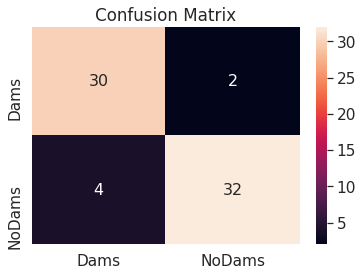

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cf

df_cm = pd.DataFrame(array,index = [i for i in["Dams","NoDams"]], columns = [i for i in["Dams","NoDams"]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.title("Confusion Matrix")
plt.show()

This is the final model where we have used 7 Convolution layers and 4 fully connected layers with batch size 32. We ran the model for 20 epochs, used accuracy, precision and recall from keras as metrics. We have used Adam optimizer and binary cross entropy loss. For this model we achieved 88% training and 91% test accuracies.